# Import

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input, AveragePooling2D, Lambda
from urllib import request
from keras.callbacks import TensorBoard, ModelCheckpoint
import tempfile
from keras import optimizers
from keras.utils import Sequence
import numpy as np
from tqdm import tqdm
from datetime import datetime
from keras.applications import vgg16, resnet50
from glob import glob
from IPython.display import Image
import json

Using TensorFlow backend.


# Utils

In [2]:
def mkdir(path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define parameters

In [3]:
ROOT_DIR = './data/dog-breed'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
MODELS_DIR = './data/models/2/'
LOGS_DIR = './data/logs/'

EPOCHS = 50
BATCH_SIZE = 2048
IMAGE_SIZE = (224,224)
INPUT_SHAPE = IMAGE_SIZE + (3,)

mkdir(MODELS_DIR)

# Fetch data (if not exist)

In [4]:
def fetch_data():
    if not os.path.exists(ROOT_DIR):
        os.makedirs(ROOT_DIR)
        zip_path = os.path.join(tempfile.gettempdir(), 'dog-breed.zip')
        print('Start download!')
        request.urlretrieve('https://kienle.blob.core.windows.net/public/kaggle/dog-breed.zip', zip_path)
        print('Start unzip')
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'test.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'train.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        os.remove(zip_path)
        os.remove(os.path.join(ROOT_DIR,'train.zip'))
        os.remove(os.path.join(ROOT_DIR,'test.zip'))
        print('Done')
fetch_data()

In [5]:
# Confirm all data are ready 
# Expected output: labels.csv  sample_submission.csv  test  train
!ls $ROOT_DIR

labels.csv  sample_submission.csv  test  train


# Explore dataset

In [6]:
pd_images = pd.read_csv(os.path.join(ROOT_DIR, 'labels.csv'))

In [7]:
pd_images.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


boston_bull


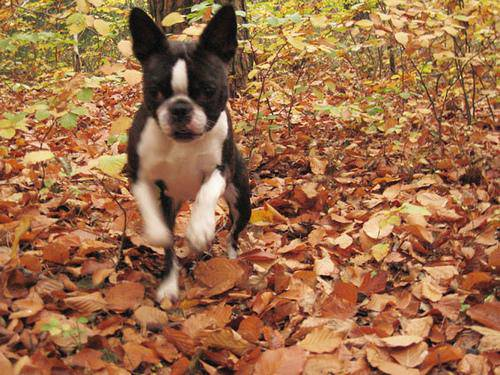

In [8]:
title = pd_images.breed[0]
path = os.path.join(TRAIN_DIR, pd_images.id[0] + '.jpg')
print(title)
Image(filename=path)

# Load images by ImageDataGenerator

In [9]:
image_gen = ImageDataGenerator()

In [10]:
train_valid_generator = image_gen.flow_from_dataframe(pd_images, TRAIN_DIR, batch_size=BATCH_SIZE, x_col='id', y_col='breed', has_ext=False, target_size=IMAGE_SIZE)

Found 10222 images belonging to 120 classes.


In [11]:
num_classes = len(train_valid_generator.class_indices)

In [12]:
train_valid_generator.class_indices

{'boston_bull': 0,
 'dingo': 1,
 'pekinese': 2,
 'bluetick': 3,
 'golden_retriever': 4,
 'bedlington_terrier': 5,
 'borzoi': 6,
 'basenji': 7,
 'scottish_deerhound': 8,
 'shetland_sheepdog': 9,
 'walker_hound': 10,
 'maltese_dog': 11,
 'norfolk_terrier': 12,
 'african_hunting_dog': 13,
 'wire-haired_fox_terrier': 14,
 'redbone': 15,
 'lakeland_terrier': 16,
 'boxer': 17,
 'doberman': 18,
 'otterhound': 19,
 'standard_schnauzer': 20,
 'irish_water_spaniel': 21,
 'black-and-tan_coonhound': 22,
 'cairn': 23,
 'affenpinscher': 24,
 'labrador_retriever': 25,
 'ibizan_hound': 26,
 'english_setter': 27,
 'weimaraner': 28,
 'giant_schnauzer': 29,
 'groenendael': 30,
 'dhole': 31,
 'toy_poodle': 32,
 'border_terrier': 33,
 'tibetan_terrier': 34,
 'norwegian_elkhound': 35,
 'shih-tzu': 36,
 'irish_terrier': 37,
 'kuvasz': 38,
 'german_shepherd': 39,
 'greater_swiss_mountain_dog': 40,
 'basset': 41,
 'australian_terrier': 42,
 'schipperke': 43,
 'rhodesian_ridgeback': 44,
 'irish_setter': 45,
 'a

# Feature extractions using pretrained models

In [13]:
def FeaturesExtractor(input_shape, pretrained_model, preprocess_input):
    model = pretrained_model(include_top=False, input_shape=input_shape, weights='imagenet')
    inputs = Input(input_shape)
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = model(x)
    x = GlobalAveragePooling2D()(x)
    return Model(inputs, x)

# Prepare training dataset

In [14]:
X_train = np.zeros((train_valid_generator.n,) + INPUT_SHAPE)
y_train = np.zeros((train_valid_generator.n, 120))
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    temp_x, temp_y = train_valid_generator[i]
    start_index = i*train_valid_generator.batch_size
    X_train[start_index:start_index + temp_x.shape[0]] = temp_x
    y_train[start_index:start_index + temp_x.shape[0]] = temp_y


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.86s/it]


# Model creation function

In [15]:
def create_simple_model(num_classes, input_shape):
    inputs = Input(input_shape)
    x = inputs
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, x)

# Use vgg16

In [16]:
vgg_features_extractor = FeaturesExtractor(INPUT_SHAPE, vgg16.VGG16, vgg16.preprocess_input)

In [17]:
# Calculate vgg features
vgg_features = vgg_features_extractor.predict(X_train)

vgg_based_model = create_simple_model(num_classes, vgg_features_extractor.output.get_shape().as_list()[1:])
vgg_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath= MODELS_DIR + "model-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [TensorBoard( LOGS_DIR +'vgg-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0])),
            checkpoint
            ]
    
vgg_based_model.summary()

In [19]:
vgg_based_model.fit(vgg_features, y_train, batch_size=256, epochs=EPOCHS, callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 1s 85us/step - loss: 14.8041 - acc: 0.0186 - val_loss: 12.4809 - val_acc: 0.0635

Epoch 00001: val_acc improved from -inf to 0.06354, saving model to ./data/models/1/model-weights-01-0.06.hdf5
Epoch 2/50
9199/9199 [==============================] - 0s 20us/step - loss: 13.6767 - acc: 0.0529 - val_loss: 10.8560 - val_acc: 0.1281

Epoch 00002: val_acc improved from 0.06354 to 0.12805, saving model to ./data/models/1/model-weights-02-0.13.hdf5
Epoch 3/50
9199/9199 [==============================] - 0s 21us/step - loss: 12.4610 - acc: 0.0956 - val_loss: 9.1097 - val_acc: 0.2141

Epoch 00003: val_acc improved from 0.12805 to 0.21408, saving model to ./data/models/1/model-weights-03-0.21.hdf5
Epoch 4/50
9199/9199 [==============================] - 0s 21us/step - loss: 11.0851 - acc: 0.1413 - val_loss: 7.5648 - val_acc: 0.2903

Epoch 00004: val_acc improved from 0.21408 to 0.29032, saving m


Epoch 00035: val_acc did not improve from 0.65787
Epoch 36/50
9199/9199 [==============================] - 0s 19us/step - loss: 2.0814 - acc: 0.6712 - val_loss: 2.2718 - val_acc: 0.6500

Epoch 00036: val_acc did not improve from 0.65787
Epoch 37/50
9199/9199 [==============================] - 0s 18us/step - loss: 2.0743 - acc: 0.6716 - val_loss: 2.2055 - val_acc: 0.6432

Epoch 00037: val_acc did not improve from 0.65787
Epoch 38/50
9199/9199 [==============================] - 0s 19us/step - loss: 2.0356 - acc: 0.6775 - val_loss: 2.2417 - val_acc: 0.6442

Epoch 00038: val_acc did not improve from 0.65787
Epoch 39/50
9199/9199 [==============================] - 0s 19us/step - loss: 1.9886 - acc: 0.6812 - val_loss: 2.2341 - val_acc: 0.6403

Epoch 00039: val_acc did not improve from 0.65787
Epoch 40/50
9199/9199 [==============================] - 0s 20us/step - loss: 2.0082 - acc: 0.6745 - val_loss: 2.2347 - val_acc: 0.6364

Epoch 00040: val_acc did not improve from 0.65787
Epoch 41/50
91

# Use resnet50

In [20]:
resnet50_features_extractor = FeaturesExtractor(INPUT_SHAPE, resnet50.ResNet50, resnet50.preprocess_input)

/home/trule/miniconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [21]:
resnet50_features = resnet50_features_extractor.predict(X_train)

In [22]:
resnet50_based_model = create_simple_model(num_classes, resnet50_features_extractor.output.get_shape().as_list()[1:])
resnet50_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [TensorBoard(LOGS_DIR +'resnet50-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0]))]

In [23]:
resnet50_based_model.fit(resnet50_features, y_train, batch_size=256, epochs=EPOCHS,  callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 1s 68us/step - loss: 3.9122 - acc: 0.1750 - val_loss: 1.8281 - val_acc: 0.5718
Epoch 2/50
9199/9199 [==============================] - 0s 28us/step - loss: 1.6948 - acc: 0.5365 - val_loss: 1.1987 - val_acc: 0.6872
Epoch 3/50
9199/9199 [==============================] - 0s 28us/step - loss: 1.1595 - acc: 0.6655 - val_loss: 1.0238 - val_acc: 0.7253
Epoch 4/50
9199/9199 [==============================] - 0s 26us/step - loss: 0.9191 - acc: 0.7291 - val_loss: 0.9266 - val_acc: 0.7498
Epoch 5/50
9199/9199 [==============================] - 0s 26us/step - loss: 0.7853 - acc: 0.7705 - val_loss: 0.8921 - val_acc: 0.7498
Epoch 6/50
9199/9199 [==============================] - 0s 28us/step - loss: 0.6754 - acc: 0.8003 - val_loss: 0.8612 - val_acc: 0.7625
Epoch 7/50
9199/9199 [==============================] - 0s 28us/step - loss: 0.5919 - acc: 0.8274 - val_loss: 0.8379 - val_acc: 0.7713
Epoch 8

# Confusion matrix (VGG)

In [24]:
index2labels = {}
for k, v in train_valid_generator.class_indices.items():
    index2labels[v] = k

In [25]:
preds = []
targets = []
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    x, y = train_valid_generator[i]
    p = vgg_based_model.predict(vgg_features_extractor.predict(x))
    p = np.argmax(p, axis=1)    
    y = np.argmax(y, axis=1)
    preds = np.concatenate((preds, p))
    targets = np.concatenate((targets, y))
from sklearn.metrics import confusion_matrix
print(np.sum(targets == preds))
print(preds[0:10])
print(targets[0:10])
cm = confusion_matrix(targets, preds)
print(cm[0:10, 0:10])

100%|█████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.71s/it]

9117
[52. 76. 89. 42. 95. 63. 59.  6. 40. 92.]
[52. 76. 89. 42. 95. 63. 59.  6. 40. 92.]
[[ 83   0   0   0   0   0   0   0   0   0]
 [  0  68   0   0   0   0   0   3   0   0]
 [  0   0  69   0   0   0   0   0   0   0]
 [  0   0   0  81   0   0   0   0   0   0]
 [  0   0   0   0  57   0   0   0   0   0]
 [  0   0   0   0   0  86   0   0   0   0]
 [  0   0   0   0   0   0  69   0   0   2]
 [  0   0   0   0   0   0   0 105   0   0]
 [  0   0   0   0   0   0   0   0 117   0]
 [  0   0   0   0   0   0   0   0   0  74]]


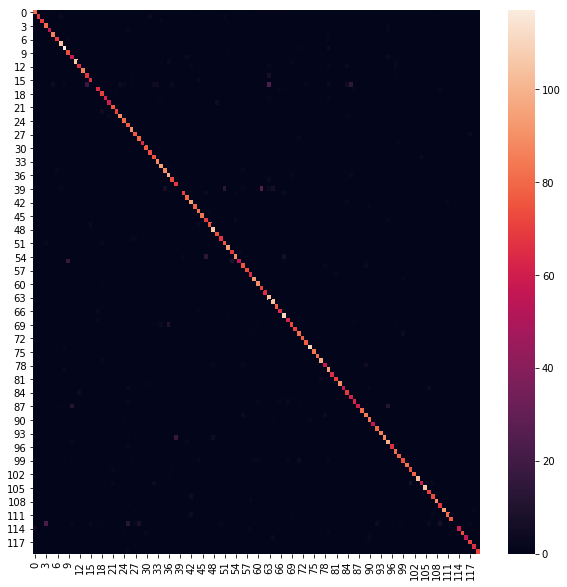

In [26]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=False)

# Save models and data for prediction

In [27]:
vgg_features_extractor.save(MODELS_DIR + 'model-weights-vgg_features_extractor.hdf5')

In [28]:
with open(MODELS_DIR + 'model-classes.json', 'w') as f:
    f.write(json.dumps(train_valid_generator.class_indices))